<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/Image_classification_with_Swin_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image classification with Swin Transformers**

**Swin Transformer (Shifted Window Transformer) can serve as a general-purpose backbone for computer vision. Swin Transformer is a hierarchical Transformer whose representations are computed with shifted windows. The shifted window scheme brings greater efficiency by limiting self-attention computation to non-overlapping local windows while also allowing for cross-window connections. This architecture has the flexibility to model information at various scales and has a linear computational complexity with respect to image size.**

In [ ]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 6.2 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
num_classes = 100
input_shape = (32, 32, 3)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(f"x_train shape is :: {x_train.shape}, y_train shape is :: {y_train.shape}")
print(f"x_test shape is :: {x_test.shape}, y_test shape is :: {y_test.shape}")

169001437/169001437 [==============================] - 2s 0us/step
x_train shape is :: (50000, 32, 32, 3), y_train shape is :: (50000, 100)
x_test shape is :: (10000, 32, 32, 3), y_test shape is :: (10000, 100)


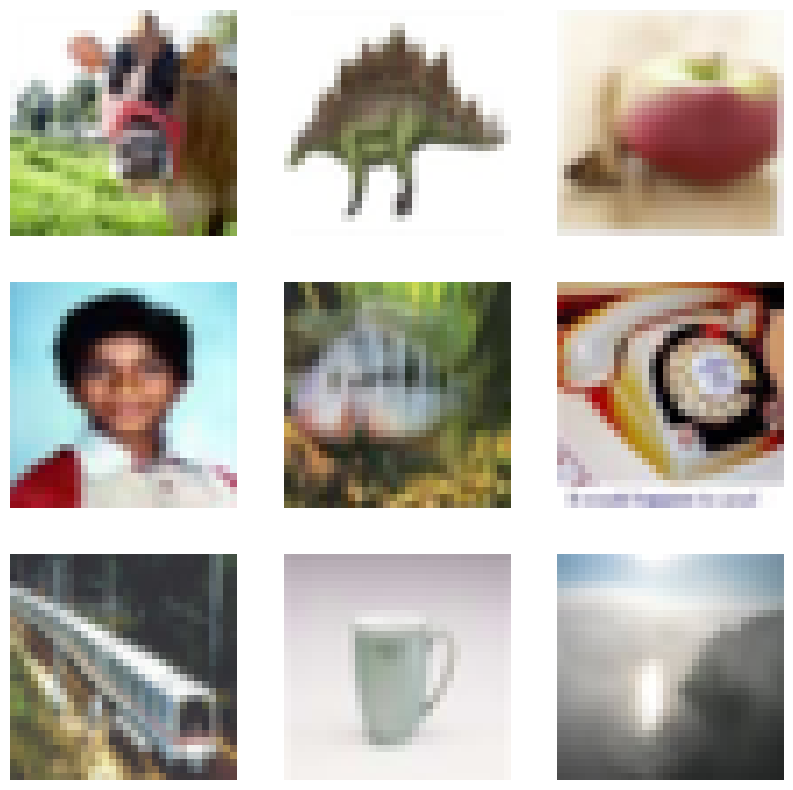

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(x_train[i])
  plt.xticks([])
  plt.yticks([])
  plt.axis("off")
plt.show()

In [ ]:
patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 32  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 128
num_epochs = 40
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

**Helper functions**

We create two helper functions to help us get a sequence of patches from the image, merge patches, and apply dropout.

In [ ]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output

**Window based multi-head self-attention**

Usually Transformers perform global self-attention, where the relationships between a token and all other tokens are computed. The global computation leads to quadratic complexity with respect to the number of tokens. Here, as the original paper suggests, we compute self-attention within local windows, in a non-overlapping manner. Global self-attention leads to quadratic computational complexity in the number of patches, whereas window-based self-attention leads to linear complexity and is easily scalable.

In [ ]:
class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv

**The complete Swin Transformer model**

Finally, we put together the complete Swin Transformer by replacing the standard multi-head attention (MHA) with shifted windows attention. As suggested in the original paper, we create a model comprising of a shifted window-based MHA layer, followed by a 2-layer MLP with GELU nonlinearity in between, applying LayerNormalization before each MSA layer and each MLP, and a residual connection after each of these layers.

Notice that we only create a simple MLP with 2 Dense and 2 Dropout layers. Often you will see models using ResNet-50 as the MLP which is quite standard in the literature. However in this paper the authors use a 2-layer MLP with GELU nonlinearity in between.

In [ ]:
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x

**Model training and evaluation**

**Extract and embed patches**

We first create 3 layers to help us extract, embed and merge patches from the images on top of which we will later use the Swin Transformer class we built.

In [ ]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super().__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)

In [ ]:
input = layers.Input(input_shape)
x = layers.RandomCrop(image_dimension, image_dimension)(input)
x = layers.RandomFlip("horizontal")(x)
x = PatchExtract(patch_size)(x)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)

In [ ]:
model = keras.Model(input, output)
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=validation_split,
)

Epoch 1/40
352/352 [==============================] - 37s 75ms/step - loss: 4.1780 - accuracy: 0.0806 - top-5-accuracy: 0.2529 - val_loss: 3.8998 - val_accuracy: 0.1148 - val_top-5-accuracy: 0.3610
Epoch 2/40
352/352 [==============================] - 26s 74ms/step - loss: 3.7415 - accuracy: 0.1593 - top-5-accuracy: 0.4163 - val_loss: 3.6769 - val_accuracy: 0.1766 - val_top-5-accuracy: 0.4436
Epoch 3/40
352/352 [==============================] - 26s 73ms/step - loss: 3.5385 - accuracy: 0.2062 - top-5-accuracy: 0.4923 - val_loss: 3.4642 - val_accuracy: 0.2294 - val_top-5-accuracy: 0.5134
Epoch 4/40
352/352 [==============================] - 26s 73ms/step - loss: 3.3905 - accuracy: 0.2367 - top-5-accuracy: 0.5408 - val_loss: 3.3706 - val_accuracy: 0.2418 - val_top-5-accuracy: 0.5492
Epoch 5/40
352/352 [==============================] - 25s 72ms/step - loss: 3.2921 - accuracy: 0.2650 - top-5-accuracy: 0.5714 - val_loss: 3.2933 - val_accuracy: 0.2654 - val_top-5-accuracy: 0.5672
Epoch 6/40

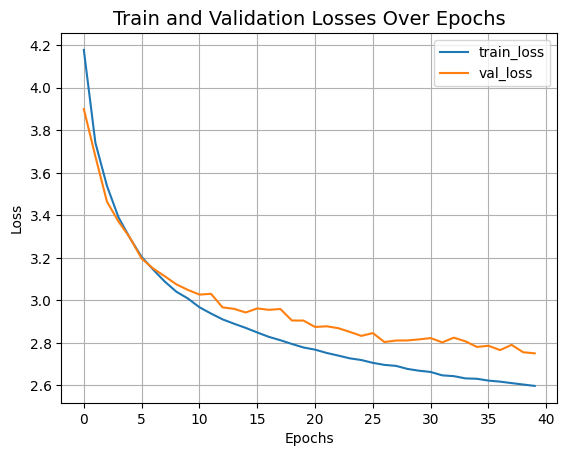

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [ ]:

loss, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

313/313 [==============================] - 4s 14ms/step - loss: 2.7082 - accuracy: 0.4262 - top-5-accuracy: 0.7329
Test loss: 2.71
Test accuracy: 42.62%
Test top 5 accuracy: 73.29%



The Swin Transformer model we just trained has just 152K parameters, and it gets us to ~75% test top-5 accuracy within just 40 epochs without any signs of overfitting as well as seen in above graph. This means we can train this network for longer (perhaps with a bit more regularization) and obtain even better performance. This performance can further be improved by additional techniques like cosine decay learning rate schedule, other data augmentation techniques. While experimenting, I tried training the model for 150 epochs with a slightly higher dropout and greater embedding dimensions which pushes the performance to ~72% test accuracy on CIFAR-100 as you can see in the screenshot.

The authors present a top-1 accuracy of 87.3% on ImageNet. The authors also present a number of experiments to study how input sizes, optimizers etc. affect the final performance of this model. The authors further present using this model for object detection, semantic segmentation and instance segmentation as well and report competitive results for these. You are strongly advised to also check out the original paper.